## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, GenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
import plastid
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm

In [3]:
# Define the path to our Bam files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/"
position_count_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/ecol/"
te_table_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/ecol/'
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/"
save_path2 = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/initiation_rates/ecol/"
save_path3 = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/termination_rates/ecol/"
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
mutation = 'efp'
samp_num = '2'

## Loading up the data files 

In [4]:
init_mutant = np.loadtxt(save_path2 + mutation + '_' + samp_num + '_adjusted_initiation_rates', delimiter = ",")

In [5]:
term_mutant = np.loadtxt(save_path3 + mutation + '_' + samp_num + '_adjusted_termination_rates', delimiter = ",")
master_index = np.loadtxt(save_path3 + mutation + '_' + samp_num + 'master_index', delimiter = ",")

In [6]:
master_index = list(master_index.astype(int))

In [7]:
def load_elongation_rates_v2(csv_name, csv_path):
    data = []
    gene_names = []
    with open(csv_path + csv_name, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    blank=data.pop(0)
            
    for i,ii in zip(data, range(len(data))):
        for j,jj in zip(i, range(len(i))):
            try:
                x = float(j)
                data[ii][jj] = x
            except:
                pass
            
    # Remove empty space
    for i,ii in zip(data, range(len(data))):
        x = list(filter(('').__ne__, i))
        data[ii] = x
        
    # Convert lists to np.arrays
    for i,ii in zip(data, range(len(data))):
        gene_names.append(data[ii][0])
        data[ii] = np.array(data[ii][1:]) # I think that this is my target, I just need it to also capture
    
    return data, gene_names

def load_count_positions_v2(csv_name, csv_path):
    data = []
    gene_names = []
    with open(csv_path + csv_name, newline = '') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    blank=data.pop(0)
            
    for i,ii in zip(data, range(len(data))):
        for j,jj in zip(i, range(len(i))):
            try:
                x = int(float(j))
                data[ii][jj] = x
            except:
                pass
            
    # Remove empty space
    for i,ii in zip(data, range(len(data))):
        x = list(filter(('').__ne__, i))
        data[ii] = x
        
    # Convert lists to np.arrays
    for i,ii in zip(data, range(len(data))):
        gene_names.append(data[ii][1])
        data[ii] = np.array(data[ii][2:])
    
    return data, gene_names

In [8]:
# Load in the elongation rates data.
elon_mutant, gene_names = load_elongation_rates_v2(mutation + '_' + samp_num + '_adjusted_elongation_rates', elon_path)

In [9]:
# Load in the count positions data.
counts, genes = load_count_positions_v2(mutation+"_"+samp_num+"_counts.csv",position_count_path)

In [10]:
fixed_counts = []
for i in master_index:
    fixed_counts.append(counts[i])

## Define functions

In [11]:
def get_density(lamb, a, B, I = 10, intermediates = False):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p = low_density(lamb_c, a, I)
        density = "LD"
    elif a > crit_a and B < crit_B:
        p = high_density(lamb_c, B, I)
        density = "HD"
    elif a < crit_a and B < crit_B:
        Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
        JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
        sign = Jl - JR 
        if sign > 0:
            p = low_density(lamb_c, a, I)
            density = "LD"
        elif sign < 0:
            p = high_density(lamb_c, B, I)
            density = "HD"
    elif a > crit_a and B > crit_B:
        p = maximum_current(lamb_c, a, B, I)
        density = "MC"
    if intermediates == False:
        return p, density
    elif intermediates == True:
        return p, a, B, crit_a, crit_B, min(lamb_c), lamb_c[0]
    
def get_critical_values(lamb, a, B, I = 10):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    return(crit_a, crit_B)

## Clean data

In [12]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
clean_elons = []
clean_inits = []
clean_terms = []
clean_gene_names = []
clean_tr_ids = []
for tr_m, el_m, in_m, term_m, gi in zip(fixed_counts, elon_mutant, init_mutant, term_mutant, gene_names):
    #if len(tr_m) > 100 and sum(tr_m)/len(tr_m) > 0.15 and np.any(el_m<0) == False:
        clean_elons.append(el_m)
        clean_inits.append(in_m)
        clean_terms.append(term_m)
        clean_gene_names.append(gi)

In [13]:
crit_as = []
crit_Bs = []
for ce, ci, ct in zip(clean_elons, clean_inits, clean_terms):
    crit_a, crit_B = get_critical_values(ce, ci, ct)
    crit_as.append(crit_a)
    crit_Bs.append(crit_B)

---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in sqrt
in /tmp/ipykernel_4976/4077287372.py, line 34:

32     Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
33     crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
34     crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
35     return(crit_a, crit_B)

---------------------------------------------------------------------------
---------------------------------------------------------------------------
RuntimeWarning
invalid value encountered in sqrt
in /tmp/ipykernel_4976/4077287372.py, line 33:

31     lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
32     Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
33     crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
34     crit_B = ((lamb_

In [14]:
ratio_a = (np.array(clean_inits)/np.array(crit_as))
ratio_B = (np.array(clean_terms))/np.array(crit_Bs)

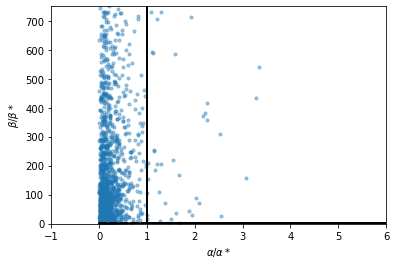

In [15]:
plt.scatter(ratio_a, ratio_B, s = 10, alpha = 0.4)
plt.ylim([-1,750])
plt.xlim([-1,6])
plt.xlabel(r'$\alpha / \alpha * $')
plt.ylabel(r'$\beta / \beta * $')
plt.plot([1, 1], [1, 2000], 'k-', lw=2)
plt.plot([1, 200], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

In [16]:
df = pd.DataFrame(list(zip(clean_gene_names, ratio_a, ratio_B)), columns = ["Gene", "ratio_a", "ratio_B"])

In [18]:
df[df.Gene == "cysQ"]

,Gene,ratio_a,ratio_B
1710,cysQ,0.045934,157.201487


In [19]:
df[df.ratio_a > 3]

,Gene,ratio_a,ratio_B
23,lptD,3.726983,6801.578808
25,rluA,3.335709,541.708214
27,araC,13.409890,9137.954525
40,ftsI,9.903898,219.131851
163,acpH,4.475961,1141.011729
277,lnt,6.323056,927.419894
385,ybjT,3.284255,434.208601
424,pqiB,5.715270,3567.105330
613,ydcR,10.203318,15675.052162
630,eamA,3.061076,157.887863


## Next Step, look at Mutant

Also, calculate the median or mean change in elongation rate necessary to induce elongation limitation

In [20]:
x = 0
for i in ratio_B:
    x = x+1
    if i < 0:
        print(i)
        print(x)

-61716.88610046346
65
-5774.530156771902
78
-224.5490604948802
200
-5111.478341949862
207
-28.900428881076493
213
-3858.58618886846
223
-4.737152292906603
255
-15.44137404496037
383
-5725.221252515455
572
-819.5677820621275
634
-30.98741124946747
723
-1.4099734877239707
975
-233.20791743608117
1715


In [21]:
clean_gene_names[120]

'ivy'

## Look at just the Fmr1 targets

In [22]:
# Load up the target gene names. 
PPP_table = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/data_tables/' + 'polyproline_motifs.csv')

# Load up the tables of KS statistics
df_ecol = pd.read_csv(ks_ecol_path + "ks_table_" + samp_num + ".csv")

NameError: name 'ks_ecol_path' is not defined

In [ ]:
# Correct the column headings and rows for the polyproline table. 
PPP_table.columns = PPP_table.iloc[2]
PPP_table = PPP_table.drop([0,1,2])

# Remove the many unecessary columns from the polyproline data
PPP_table = pd.DataFrame(PPP_table.Gene.unique(), columns = ["Gene"])

# Merge the ecoli ks table with the list of gene names
PPP_ks_table = pd.merge(df_ecol, PPP_table, how='inner', right_on='Gene', left_on='gene_ID')

In [ ]:
# Several genes have multiple polyproline motifs and thus appear multiple times in the PPP table
# Keep only one copy of each gene in the PPP table. 
PPP_ks_table.sort_values("Gene", inplace = True)
PPP_ks_table.drop_duplicates(subset ="Gene",keep = "first", inplace = True) 

In [ ]:
Fmr1_crit_as = []
Fmr1_crit_Bs = []
for ce, ci, ct in zip(Fmr1_elon_table.elon_rate, Fmr1_elon_table.a, Fmr1_elon_table.B):
    crit_a, crit_B = get_critical_values(ce, ci, ct)
    Fmr1_crit_as.append(crit_a)
    Fmr1_crit_Bs.append(crit_B)

In [ ]:
ratio_a = (np.array(Fmr1_elon_table.a)/np.array(Fmr1_crit_as))
ratio_B = (np.array(Fmr1_elon_table.B))/np.array(Fmr1_crit_Bs)

In [ ]:
Fmr1_elon_table["ratio_a"] = ratio_a
Fmr1_elon_table["ratio_B"] = ratio_B

In [ ]:
plt.scatter(ratio_a, ratio_B/10, s = 10, alpha = 0.4)
plt.ylim([-.5,16])
plt.xlim([-.5,9])
plt.plot([1, 1], [1, 18], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

In [ ]:
Fmr1_elon_table[Fmr1_elon_table.ratio_a > 0.6]

From what I can see, no matter what, TASEP only cares about the minimum elongation rate (proportional to the strongest pause) and the initiation rate (proportional to the first pause)

show reduced elongation rate by 50% and look at how that effects it. 